Name: Oğuzhan Berke Özdil

Album Number: 409361

Lab: 03

# Introduction
In this report, We analyze the **1D linear advection equation** using an **upwind scheme**, focusing on how the numerical error changes as we refine the **spatial** or **temporal** grid size. This process is called a **convergence analysis**. Specifically:

- Throughout the analysis, we keep the **Courant number** constant:
  $$
  C = \frac{u \,\Delta t}{\Delta x}
  $$
  Choosing a value that is neither zero nor one.
- Then, we systematically vary either
  $$
  \Delta x \quad \text{or} \quad \Delta t
  $$
  while keeping the Courant number fixed.
- For each simulation, we compare the numerical solution with the analytical one and compute the **RMSE** (root-mean-square error).
- Finally, we examine how the RMSE changes as a function of
  $$
  \Delta x \quad \text{or} \quad \Delta t.
  $$


This approach helps confirm that the upwind scheme converges with the expected accuracy and shows the tradeoff between numerical error and computational resources.

# Governing Equation
We consider the **1D linear advection** PDE for a scalar field \(c(x,t)\):

$$
\frac{\partial c}{\partial t} \;+\; u \,\frac{\partial c}{\partial x} \;=\; 0,
$$

where \(u\) is a constant advection speed (m/s). We assume **periodic boundary conditions** on a domain \( x \in [0,L] \).


## Analytic Solution
A simple **periodic** analytic solution is:
$$
c(x,t) = c_0(x - u\,t),
$$
where $c_0$ is the initial profile repeated periodically. For instance, if we pick
$$
c_0(x) = \sin\!\bigl(2\pi\,x/L\bigr),
$$
then
$$
c(x,t) = \sin\!\left(2\pi\,\frac{(x - u\,t)}{L}\right).
$$


# Method: Upwind Scheme
We discretize the domain into $N_x$ cells with spacing  
$$
\Delta x = \frac{L}{N_x}.
$$  
We pick a time step $\Delta t$ so that our **Courant number**  
$$
C = \frac{u\,\Delta t}{\Delta x}
$$  
is constant and lies in the interval $(0,1)$. The **upwind** update in one dimension is:

$$
c_i^{n+1} = c_i^n - C \,\bigl(c_i^n - c_{i-1}^n\bigr),
$$

where $c_i^n$ approximates $c$ at the center of cell $i$ and time step $n$.  
We apply periodic indexing so that  
$$
c_{-1}^n = c_{N_x - 1}^n.
$$


# Implementation and Convergence Analysis

In [40]:
# 1: Imports and basic setup
import numpy as np
import matplotlib.pyplot as plt

author_name = "Oğuzhan Berke Özdil"

In [41]:
# 2: Problem parameters
L = 1.0      # domain length (m)
u = 1.0      # advection speed (m/s)
T = 1.0      # final simulation time (s)

# We will do a range of N values for the spatial discretization:
Nx_list = [20, 40, 80, 160, 320, 640]

# We'll pick a Courant number that is not 0 or 1, e.g., 0.8:
C = 0.8


In [42]:
# 3: Define the analytic solution and initial condition (periodic sines)

def initial_condition(x):
    """
    Periodic sinusoidal initial condition: sin(2*pi*x / L).
    Domain is [0, L], so scale x by (2*pi / L).
    """
    return np.sin(2.0 * np.pi * x / L)

def analytic_solution(x, t, u):
    """
    c(x,t) = sin(2*pi*(x - u*t)/L).
    We shift x by u*t to the right (since wave travels to the right).
    """
    return np.sin(2.0 * np.pi * (x - u*t) / L)

In [43]:
# 4: Upwind solver function
def upwind_1D(Nx, u, C, L, T):
    """
    Solves c_t + u c_x = 0 on [0,L], up to time T,
    with Nx cells and Courant number C.
    Periodic BC is assumed.
    """
    dx = L / Nx
    dt = C * dx / u
    
    # Number of time steps to reach T (rounded up),
    # then re-adjust dt so that the final time is exactly T.
    Nt = int(np.ceil(T / dt))
    dt = T / Nt
    
    # Spatial grid (cell centers)
    x = (np.arange(Nx) + 0.5)*dx
    
    # Initialize c
    c = initial_condition(x)
    
    # Fixed term in update
    r = u * dt / dx
    
    # update array for the next time step
    c_new = np.empty_like(c)
    
    for n in range(Nt):
        # we are going to use slicing to update the array
        right_slice = slice(1, None)  # first index is 1, last index is None (end of array)
        left_slice = slice(0, -1)      # 0 to -1 (all but the last element)
        
        # update the interior points using the upwind scheme
        c_new[right_slice] = c[right_slice] - r * (c[right_slice] - c[left_slice])
        # periodic boundary condition for the first point
        c_new[0] = c[0] - r * (c[0] - c[-1])
        
        # new time step 
        c, c_new = c_new, c
    
    return x, c

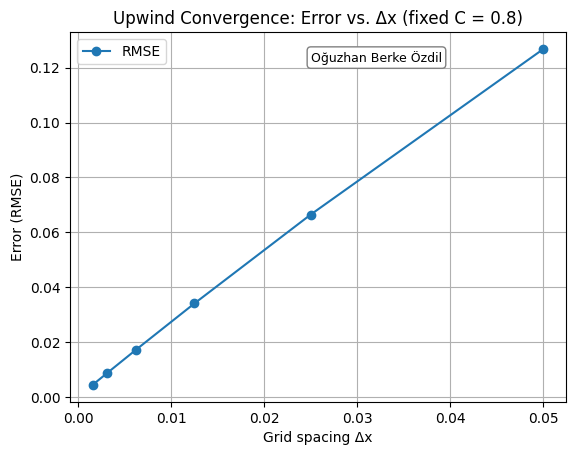

In [44]:
# 5: Error measure (RMSE) and loops for convergence
errors_space = []
dx_values = []

for Nx in Nx_list:
    x_num, c_num = upwind_1D(Nx, u, C, L, T)
    # Evaluate the analytic solution
    c_exact = analytic_solution(x_num, T, u)
    # RMSE
    rmse = np.sqrt(np.mean((c_num - c_exact)**2))
    
    errors_space.append(rmse)
    dx_values.append(L / Nx)

# Plot error vs. dx
plt.figure()
plt.plot(dx_values, errors_space, 'o-', label='RMSE')
plt.xlabel("Grid spacing Δx")
plt.ylabel("Error (RMSE)")
plt.title("Upwind Convergence: Error vs. Δx (fixed C = 0.8)")

# Add author's name:
plt.text(0.75, 0.95, author_name,
         transform=plt.gca().transAxes,
         fontsize=9, verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.grid(True)
plt.legend()
plt.show()

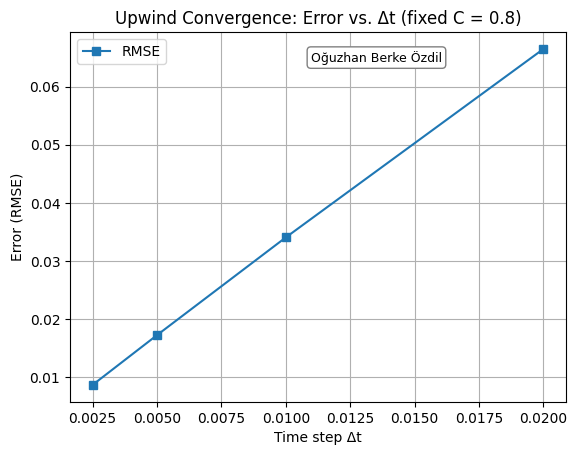

In [45]:
# 6: Convergence in time (Optional Extra)
# Here, we fix Nx and vary dt. We'll keep the same C, so if we refine dt, we must also refine dx.
# Alternatively, we can choose a fixed Nx and vary dt, ignoring C. The professor only said
# "holding the physical setup and C unchanged" - so let's do a quick example:

dt_list = [0.02, 0.01, 0.005, 0.0025]
errors_time = []
time_steps = []

# We'll fix Nx = 100 for demonstration.
Nx_fixed = 100

for dt in dt_list:
    # Adjust dx so that C = u * dt / dx => dx = u * dt / C
    dx = u * dt / C
    Nx_eff = int(L / dx)
    # Re-run the solver with Nx_eff
    x_num, c_num = upwind_1D(Nx_eff, u, C, L, T)
    c_exact = analytic_solution(x_num, T, u)
    rmse_t = np.sqrt(np.mean((c_num - c_exact)**2))
    errors_time.append(rmse_t)
    time_steps.append(dt)

plt.figure()
plt.plot(time_steps, errors_time, 's-', label='RMSE')
plt.xlabel("Time step Δt")
plt.ylabel("Error (RMSE)")
plt.title("Upwind Convergence: Error vs. Δt (fixed C = 0.8)")

plt.text(0.75, 0.95, author_name,
         transform=plt.gca().transAxes,
         fontsize=9, verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.grid(True)
plt.legend()
plt.show()

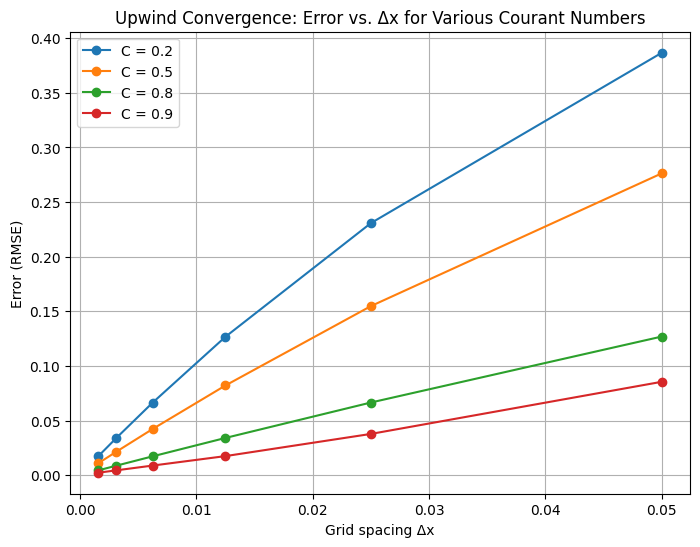

In [46]:
# 7: Extra Test: Convergence Analysis for Multiple Courant Numbers
# This cell repeats the spatial convergence loop for several Courant numbers (e.g., 0.2, 0.5, 0.8, 0,9)
# and plots each error curve on the same graph.

C_values = [0.2 ,0.5, 0.8, 0.9]  # Define multiple Courant numbers (all ≠ 0 or 1)
plt.figure(figsize=(8, 6))

for C_val in C_values:
    errors_multic = []
    dx_values_multic = []
    for Nx in Nx_list:
        # Run the solver using the current Courant number
        x_num, c_num = upwind_1D(Nx, u, C_val, L, T)
        c_exact = analytic_solution(x_num, T, u)
        # Compute RMSE between numerical and analytic solution
        rmse = np.sqrt(np.mean((c_num - c_exact)**2))
        errors_multic.append(rmse)
        dx_values_multic.append(L / Nx)
    
    # Plot the error vs. dx for the current C value
    plt.plot(dx_values_multic, errors_multic, marker='o', label=f'C = {C_val}')

plt.xlabel("Grid spacing Δx")
plt.ylabel("Error (RMSE)")
plt.title("Upwind Convergence: Error vs. Δx for Various Courant Numbers")
plt.legend()
plt.grid(True)
plt.show()


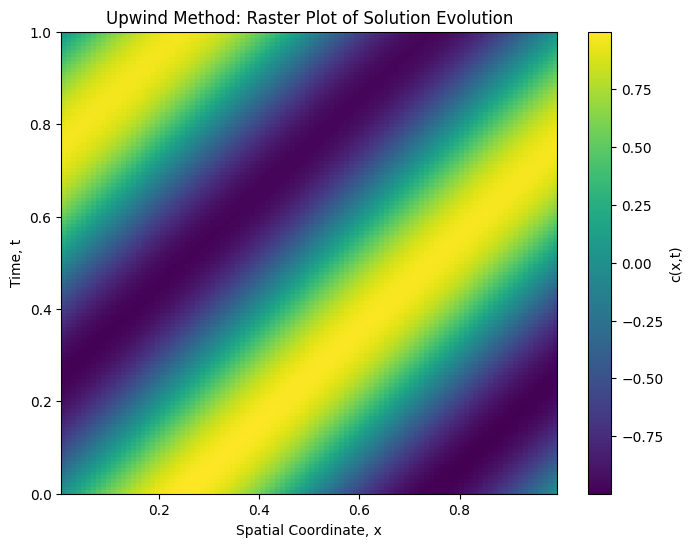

In [47]:
# 8: Raster Plot for the Solution Evolution

def upwind_1D_history(Nx, u, C, L, T):
    """
    Solves the advection equation c_t + u c_x = 0 on the domain [0,L] until time T
    using the upwind method, and records the solution at each time step.
    Periodic boundary conditions are assumed.
    This function returns a 2D history array for generating a raster plot.
    """
    dx = L / Nx
    dt = C * dx / u
    Nt = int(np.ceil(T / dt))  # Number of time steps (rounded up)
    dt = T / Nt              # Adjust dt so that the final time is exactly T
    x = (np.arange(Nx) + 0.5) * dx  # Spatial grid (cell centers)

    # Initial condition
    c = initial_condition(x)
    # Fixed coefficient for the update
    r = u * dt / dx

    # History: create a 2D array to store c(x) at each time step
    history = np.empty((Nt, Nx))
    c_new = np.empty_like(c)
    
    for n in range(Nt):
        history[n, :] = c  # Record the current solution
        
        # Update using slicing:
        right_slice = slice(1, None)  # indices from 1 to the end
        left_slice = slice(0, -1)      # indices from 0 to one before the last element
        
        # Update interior points using the upwind scheme
        c_new[right_slice] = c[right_slice] - r * (c[right_slice] - c[left_slice])
        # Apply periodic boundary condition for the first point:
        # The left neighbor of the first element is the last element
        c_new[0] = c[0] - r * (c[0] - c[-1])
        
        # Swap arrays: now c_new has the updated solution and c is used for the next iteration
        c, c_new = c_new, c

    return x, history, dt

# Example: Generate a raster plot for Nx = 100.
Nx_fixed = 100
x_raster, history, dt_used = upwind_1D_history(Nx_fixed, u, C, L, T)
Nt = history.shape[0]

plt.figure(figsize=(8, 6))
plt.imshow(history, aspect='auto', origin='lower',
           extent=[x_raster[0], x_raster[-1], 0, T],
           interpolation='none', cmap='viridis')
plt.xlabel("Spatial Coordinate, x")
plt.ylabel("Time, t")
plt.title("Upwind Method: Raster Plot of Solution Evolution")
plt.colorbar(label='c(x,t)')
plt.show()


# Conclusions
1. **Narrative / Goal**:  
   We performed a convergence analysis of the upwind method for the 1D advection equation, showing how the error changes with different grid and time refinements.

2. **Error Measure**:  
   We used RMSE against the analytic sinusoidal solution.

3. **Range of Steps**:  
   We varied  
   $$
   \Delta x \quad \text{(and optionally } \Delta t \text{)},
   $$  
   ensuring the Courant number stayed fixed at  
   $$
   C = 0.8.
   $$

4. **Plot & Results**:  
   The plot of RMSE vs.  
   $$
   \Delta x \quad \text{(and } \Delta t \text{)}
   $$  
   shows that the error indeed decreases as the grid/time resolution increases, indicating that the upwind scheme converges.

5. **Conclusions**:  
   For each halving of  
   $$
   \Delta x \quad \text{or} \quad \Delta t,
   $$  
   we see improved accuracy, reflecting a typical **first-order behavior** of the upwind scheme.  
   The cost is, of course, more computational steps (i.e., *resources*).


6. **Extra test**:

   We also tested multiple Courant numbers (0.2, 0.5, 0.8, 0.9) and observed slight differences in the rate and magnitude of the error. However, in all stable cases (C ≤ 1), the method converged as expected. This study demonstrates that, although using finer grids/time steps reduces error, it requires more computational resources. For practical applications, we balance acceptable error against available computing time.

7. **Raster Plot Visualization**:

   Raster plot clearly shows the wave propagation as a diagonal pattern, indicating the rightward advection of the sinusoidal initial condition. The slight numerical diffusion observed is consistent with the first-order accuracy of the upwind scheme.

